In [192]:
import pandas as pd
import spark
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import numpy as np


In [193]:
#read the data

activitats = pd.read_csv('data/activitats.csv')
notes = pd.read_csv('notes_arreglat.csv')
trameses = pd.read_csv('trameses_arreglat.csv')



In [194]:

# Filter activitats to keep only entries with an activitat_id present in trameses
activitats_filtered = activitats[activitats['activitat_id'].isin(trameses['activitat_id'].unique())]

# Save or display the filtered activitats DataFrame
activitats_filtered.to_csv('activitats_filtered.csv', index=False)


In [195]:
# Create a dictionary to map each unique activitat to a unique ID
activitat_unique_id = {activitats_filtered: idx for idx, activitats_filtered in enumerate(activitats_filtered['activitat'].unique(), start=1)}

# Map the activitat values to the unique IDs in the pastas column
activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)



/tmp/ipykernel_64890/311735768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)


In [196]:
# Define the aula_id values to filter
aula_ids = [87, 92, 143, 141]

activitats_filtered = activitats_filtered[activitats_filtered['aula_id'].isin(aula_ids)]

activitats_filtered.to_csv('activitats_with_shared.csv', index=False)
# Loop through each aula_id, filter, and save as a new CSV file
""" for aula_id in aula_ids:
    # Filter activitats for the current aula_id
    filtered_df = activitats_filtered[activitats_filtered['aula_id'] == aula_id]
    
    # Save the filtered DataFrame to a CSV file
    filtered_df.to_csv(f'activitats_aula_{aula_id}.csv', index=False) """


" for aula_id in aula_ids:\n    # Filter activitats for the current aula_id\n    filtered_df = activitats_filtered[activitats_filtered['aula_id'] == aula_id]\n    \n    # Save the filtered DataFrame to a CSV file\n    filtered_df.to_csv(f'activitats_aula_{aula_id}.csv', index=False) "

In [197]:
trameses_updated = trameses.merge(activitats_filtered[['activitat_id','aula_id']], on='activitat_id', how='left')
trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]
# Save the updated trameses dataset
trameses_updated.to_csv('updated_trameses.csv', index=False)


print("The aula_id has been added to the trameses dataset.")

The aula_id has been added to the trameses dataset.


In [198]:

# Step 1: Create a dictionary of unique activities per aula_id
unique_activities_per_aula = activitats_filtered.groupby('aula_id')['activitat_id'].unique().to_dict()

# Step 2: Get unique pairs of (userid, aula_id) from the existing data
unique_user_aula_pairs = trameses_updated[['userid', 'aula_id']].drop_duplicates()
unique_user_aula_pairs = unique_user_aula_pairs[unique_user_aula_pairs['aula_id'].notna()]

# Step 3: Initialize a list to store new entries
new_entries = []
id = 853717


# Step 4: Iterate over each (userid, aula_id) pair
for _, row in unique_user_aula_pairs.iterrows():
    userid = row['userid']
    aula_id = row['aula_id']
    id +=1

    
    # Get all activities associated with this aula_id
    required_activities = unique_activities_per_aula.get(aula_id, [])
    
    # Get activities that this user already has for the current aula_id
    existing_activities = trameses_updated[(trameses_updated['userid'] == userid) & (trameses_updated['aula_id'] == aula_id)]['activitat_id']
    
    # Find missing activities
    missing_activities = set(required_activities) - set(existing_activities)
    
    # Add a new entry for each missing activity
    for activitat_id in missing_activities:
        new_entry = {
            'id': id,  # Generate an id if needed
            'activitat_id': activitat_id,
            'userid': userid,
            'datesubmitted': 0,  # Fill with appropriate date if needed
            'grade': 0,
            'nevaluations': 0,
            'aula_id': aula_id,
            
        }
        new_entries.append(new_entry)

# Step 5: Create a DataFrame for the new entries and combine it with the existing entries
new_entries_df = pd.DataFrame(new_entries)
trameses_updated = pd.concat([trameses_updated, new_entries_df], ignore_index=True)
trameses_updated.to_csv('patatasbravas.csv', index=False)

# Step 6: Save the updated DataFrame to a new CSV


In [199]:
keywords = {
        "(OPCIONAL)": 3,

    "Problema": 1,
    "Entrega Practica": 2,
    "Entrega Pràctica": 2,
    "Lliurament Practica": 2,
    "Lliurament Pr�ctica": 2,
    "Lliurament Pràctica": 2,
    "Pr�ctica": 2,
    "RECUPERACI�": 3,
    "Recuperació": 3,
    "RECUPERACIÓ": 3,
    "Final FP": 4,
    "Exercici": 5,
    # Add more keywords and labels as needed
}

# Function to check for keywords in each activitat entry and assign a label
def label_activity(activitat):
    for keyword, label in keywords.items():
        if keyword in activitat:
            return label
    return 0  # Default label if no keywords match

# Apply the function to create a new 'label' column
activitats_filtered['label'] = activitats_filtered['activitat'].apply(label_activity)
activitats_filtered.to_csv('activitats_with_shared.csv', index=False)


In [200]:
# Load datasets
activitats = activitats_filtered
# rename the column 'grade' to 'max_grade'
activitats.rename(columns={'grade': 'max_grade'}, inplace=True)

trameses_updated = trameses_updated.merge(activitats[['activitat_id','shared_id','label','max_grade']], on='activitat_id', how='left')

trameses_updated.to_csv('fmunrunynyttfr.csv', index=False)


trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]
# Save the updated trameses dataset

trameses_updated.to_csv('fmunrunynyttfr.csv', index=False)

print("The aula_id has been added to the trameses dataset.")

The aula_id has been added to the trameses dataset.


In [201]:
trameses_updated = trameses_updated.sort_values(by=['shared_id', 'userid'])

In [202]:

# Initialize a dictionary to store data for each (userid, aula_id) pair
user_data = {}

# Iterate through each row in trameses
max_len = 0
for _, row in trameses_updated.iterrows():
    user_id = row['userid']
    aula_id = row['aula_id']
    grade = row['grade']
    max_grade = row['max_grade']
    shared_id = row['shared_id']
    nevaluations = row['nevaluations']
    label = row['label']
    datesubmitted = row['datesubmitted']
    
    # Use (userid, aula_id) tuple as a unique key in the dictionary
    key = (user_id, aula_id)
    
    # Initialize the list for this user-aula pair if not already created
    if key not in user_data:
        user_data[key] = []
    
    # Append the grade, datesubmitted, and aula_id to the list for this user-aula pair
    user_data[key].append([grade/max_grade,shared_id, nevaluations,datesubmitted,label]
                          
    )
    if len(user_data[key]) > max_len:
        max_len = len(user_data[key])

print(max_len)

206


In [203]:
# Flatten the user_data dictionary into an array
user_data_array = []
for key, values in user_data.items():
    user_data_array.append(np.array(values))
print(user_data_array[0])

user_data_array = np.array(user_data_array, dtype=object)


# Create a new array to store the F_Grade for each (userid, aula_id) combination
f_grade_array = []

# Iterate through the user_data_array and fetch the corresponding F_Grade from notes
for key, values in user_data.items():
    userid, aula_id = key[0], key[1]
    f_grade = notes.loc[(notes['userid'] == userid) & (notes['aula_id'] == aula_id), 'F_Grade']
    if not f_grade.empty:
        f_grade_array.append(f_grade.values[0])
    else:
        f_grade_array.append(np.nan)  # Append NaN if no F_Grade is found
    last = key
f_grade_array = np.array(f_grade_array)

print("User Data Array:")
print(user_data_array)
print("F_Grade Array:")
print(f_grade_array)



[[  1.     1.     1.  ]
 [  1.     2.     4.  ]
 [  1.     3.     1.  ]
 [  1.     4.     3.  ]
 [  1.     5.     3.  ]
 [  1.     6.     2.  ]
 [  1.     7.     2.  ]
 [  0.     8.     0.  ]
 [  1.    10.     1.  ]
 [  1.    11.     1.  ]
 [  1.    13.     1.  ]
 [  1.    14.     4.  ]
 [  1.    15.     1.  ]
 [  1.    16.     1.  ]
 [  1.    17.     1.  ]
 [  1.    18.     1.  ]
 [  1.    19.     1.  ]
 [  1.    20.     1.  ]
 [  1.    21.     1.  ]
 [  1.    22.    17.  ]
 [  1.    23.     1.  ]
 [  0.97  24.     3.  ]
 [  0.99  25.     4.  ]
 [  1.    26.     1.  ]
 [  1.    27.    14.  ]
 [  1.    28.     1.  ]
 [  0.96  29.     1.  ]
 [  1.    30.     2.  ]
 [  1.    31.     2.  ]
 [  0.99  32.     2.  ]
 [  0.    33.     0.  ]
 [  0.96  34.     1.  ]
 [  0.8   35.     5.  ]
 [  1.    37.     1.  ]
 [  1.    39.     3.  ]
 [  0.    46.     1.  ]
 [  1.   156.     1.  ]
 [  1.   157.     2.  ]
 [  0.   158.     0.  ]
 [  1.   159.     6.  ]
 [  0.   160.     1.  ]
 [  0.   161.   

In [204]:
# Find the indices where f_grade_array is NaN
nan_indices = np.isnan(f_grade_array)

# Filter out the elements in user_data_array and f_grade_array where the indices match NaN
user_data_array_filtered = user_data_array[~nan_indices]
f_grade_array_filtered = f_grade_array[~nan_indices]

print(len(user_data_array_filtered))
print(len(f_grade_array_filtered))
print(f_grade_array_filtered[-1])

701
701
5.0


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Normalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import torch
from mamba_ssm import Mamba

# Example array

# Split the array into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(user_data_array_filtered, f_grade_array_filtered, test_size=0.2, random_state=42)

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Example jagged array (list of lists with varying lengths)

# Pad sequences to a fixed length (e.g., max length of 4)
padded_data = pad_sequences(X_train, padding='post')

print("Padded Data:\n", padded_data)

# Convert to Tensor for model training
padded_data_tensor = tf.convert_to_tensor(padded_data, dtype=tf.float32)


# Hyperparameters
n_timesteps = max_len   # Number of timesteps (length of input sequence)
n_features = 5     # Number of features in each tuple (mark, date, id)
embedding_dim = 4  # Dimension for embedding the ID




batch, length, dim = 20, max_len, 4
model = Mamba(
    # This module uses roughly 3 * expand * d_model^2 parameters
    d_model=dim, # Model dimension d_model
    d_state=16,  # SSM state expansion factor
    d_conv=4,    # Local convolution width
    expand=2,    # Block expansion factor
).to("cuda")
y = model(X_test)





Padded Data:
 [[[  1   1   1]
  [  1   2   8]
  [  1   3   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  1   1   5]
  [  1   2   2]
  [  1   3   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  1   1   4]
  [  0   2   0]
  [  1   3   8]
  ...
  [  0 316   0]
  [  0 317   0]
  [  0 318   0]]

 ...

 [[  1   1   1]
  [  1   2   1]
  [  1   3   1]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  1   1   1]
  [  1   2   1]
  [  1   3   1]
  ...
  [  0 316   0]
  [  0 317   0]
  [  0 318   0]]

 [[  1   1   2]
  [  1   2   4]
  [  1   3   2]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_75 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_76 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_78 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - loss: 31.2495 - mae: 4.8935 - val_loss: 17.1134 - val_mae: 3.4975
Epoch 2/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 14.9060 - mae: 3.2468 - val_loss: 8.5426 - val_mae: 2.5003
Epoch 3/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 8.4831 - mae: 2.3630 - val_loss: 9.0571 - val_mae: 2.5249
Epoch 4/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 8.3962 - mae: 2.3827 - val_loss: 8.7675 - val_mae: 2.5682
Epoch 5/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - loss: 8.2211 - mae: 2.4326 - val_loss: 8.9151 - val_mae: 2.5855
Epoch 6/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 7.9119 - mae: 2.4160 - val_loss: 8.4593 - val_mae: 2.5168
Epoch 7/80
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 8.0165 - mae: 2.3385 - val_loss: 8.4249 - val_mae: 2.4963
Epoch 8/80
3/5 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - loss: 8.2679 - mae: 2.3603

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Example data
X = torch.randn(batch, length, dim).to("cuda")
y = torch.randint(0, 2, (batch,)).to("cuda")

# Create DataLoader
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Define the model
model = Mamba(
    d_model=dim,
    d_state=16,
    d_conv=4,
    expand=2,
).to("cuda")

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [207]:
padded_data = pad_sequences(X_test, padding='post')

print("Padded Data:\n", padded_data)

# Convert to Tensor for model training
padded_data_tensor = tf.convert_to_tensor(padded_data, dtype=tf.float32)

predicted_final_mark = model.predict(padded_data_tensor)
print("Predicted Final Mark:", predicted_final_mark)


Padded Data:
 [[[ 1  1  2]
  [ 1  2 15]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  1]
  [ 1  2  2]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  2]
  [ 1  2 12]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 ...

 [[ 1  1  1]
  [ 1  2  6]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  4]
  [ 1  2  2]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 1  1  1]
  [ 1  2  1]
  [ 1  3  1]
  ...
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step WARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x780dc6bc9300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define yo

In [208]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming `predicted_final_mark` is the vector of your predictions
# and `y_test` is the ground truth vector

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_final_mark)
print(f"Mean Absolute Error (MAE): {mae}")
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_final_mark)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(max(y_test))

Mean Absolute Error (MAE): 2.5046777976827417
Mean Squared Error (MSE): 8.356574100992692
Root Mean Squared Error (RMSE): 2.8907739622794257
10.5


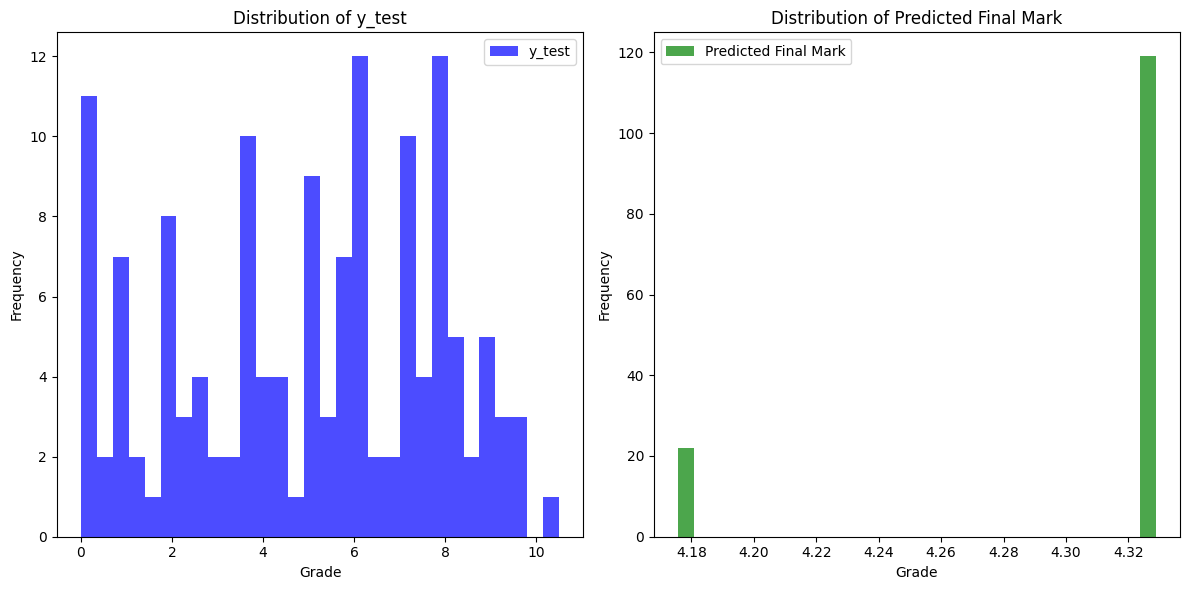

In [211]:
import matplotlib.pyplot as plt

# Plot the distribution of y_test
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, alpha=0.7, color='blue', label='y_test')
plt.title('Distribution of y_test')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.legend()

# Plot the distribution of predicted_final_mark
plt.subplot(1, 2, 2)
plt.hist(predicted_final_mark, bins=30, alpha=0.7, color='green', label='Predicted Final Mark')
plt.title('Distribution of Predicted Final Mark')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()